In [119]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import collections
from scipy.ndimage.interpolation import zoom

import scipy.io.wavfile
import collections
import wavio

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import frequency
import IPython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
base_path = '/home/michael/projects/engaged_hackathon_data/urban_8k/'
meta_path = base_path + 'UrbanSound8K/metadata/UrbanSound8K.csv'
wav_path = base_path + 'UrbanSound8K/audio/'

spectrogram_parameters = {
    'nfft': 512,
    'window_width': 0.03,
    'overlap': 0.01
    }

In [29]:
import pandas as pd
data = pd.read_csv(meta_path)

In [30]:
# # Fixing of files which scipy.io.wavfile chokes on.
# # This is done using ffmpeg from command line

# # This has I hope been coded in such a way that:
# # 1) The original filenames can be used, as given by the csv file
# # 2) The original data is preserved (as '*_original.wav' files)
# # 3) Running this multiple times will not cause unexpected effects

# import subprocess as sp
# import shutil

# for idx in data.index:

#     folder = 'fold' + str(data['fold'][idx]) + '/'
#     loadpath = wav_path + folder + data['slice_file_name'][idx]
    
#     try:
#         sample_rate, wav = scipy.io.wavfile.read(loadpath)
#     except:
        
#         # todo - this should really not be in this except bit...
#         old_file = loadpath
#         new_file = loadpath.replace('.wav', '_original.wav')

#         shutil.move(old_file, new_file)
#         command = ['ffmpeg', '-i', new_file, old_file]
#         sp.call(command)

#     if idx % 100 == 0:
#         print idx,

In [157]:
mel_convert = False
crop_height = 0.5   # set to 0.0 to not crop

# load in all the data
all_spec = []
all_fold_idxs = []

for idx in data.index:
    # load the audio and convert to spec
    folder = 'fold' + str(data['fold'][idx]) + '/'
    loadpath = wav_path + folder + data['slice_file_name'][idx]
    sample_rate, wav = scipy.io.wavfile.read(loadpath)
    
    # just take one channel of stereo files
    if len(wav.shape) == 2:  wav = wav[:, 0]
    
    spec, spec_sr = frequency.spectrogram(
        wav.ravel(), sample_rate, **spectrogram_parameters)
    spec -= np.median(spec, axis=1)[:, None]
#     spec[spec<0] = 0
    spec = spec.astype(np.float32)
    spec[np.isnan(spec)] = 0
    spec[np.isneginf(spec)] = -10
    spec[np.isposinf(spec)] = 10
    
    # convert to mel...
    if mel_convert:
        spec = frequency.spec_to_mel(spec, spec_sr, 64)
    
    # crop height
#     ss = spec.shape[0]
#     new_height = (2.0/3.0) * float(ss)
    new_height = int(spec.shape[0] * (1.0 - crop_height))
    spec = spec[:new_height, :]
    
    # resize
#     new_width = int((float(spec.shape[1] / 128.0)) * (4.0 * spec_sr))
    clip_len_seconds = spec.shape[1] / float(spec_sr)
    proportion_of_128 = float(clip_len_seconds) / 4.0
    new_width = proportion_of_128 * 128.0 + 1
    zoom_factor = (128.0 / spec.shape[0], float(new_width) / spec.shape[1])
#     spec = imresize(spec, (128, new_width))
    spec = zoom(spec, zoom_factor)
    if spec.shape[0] > 128:
        spec = spec[:128, :]
    if spec.shape[1] > 128:
        spec = spec[:, :128]
         
    # add to the list
    all_spec.append(spec.astype(np.float32))
    all_fold_idxs.append(data['fold'][idx])
    
    if idx % 100 == 0:
        print "stop", idx,

stop 0 stop 100 stop 200 stop 300 stop 400 stop 500 stop 600 stop 700 stop 800 stop 900 stop 1000 stop 1100 stop 1200 stop 1300 stop 1400

KeyboardInterrupt: 

 (128, 11)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 21)


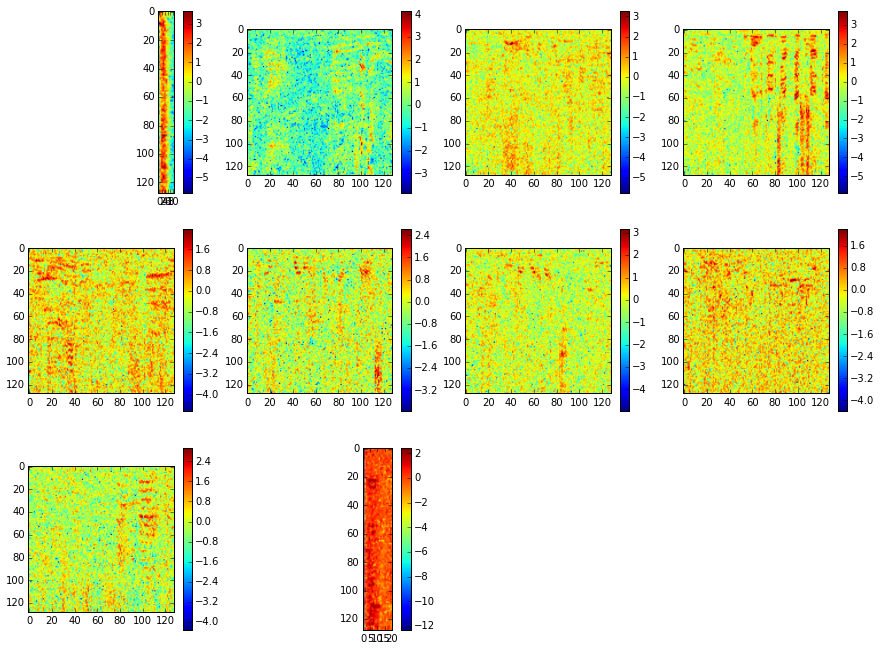

In [134]:
# plotting some
plt.figure(figsize=(15, 15))
for count, spec in enumerate(all_spec[:10]):
    plt.subplot(4, 4, count+1)
    plt.imshow(spec)
    print spec.shape
#     plt.clim(0, 5)/
    plt.colorbar()

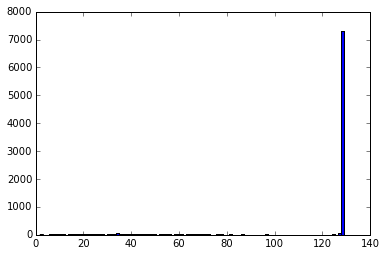

In [104]:
plt.hist([ss.shape[1] for ss in all_spec], 100);
    

In [154]:
# save unpadded spectrograms...


In [155]:
# pad specs which are too short. 
# create a new list in the process... (might need to revert to modifying the list...)
same_len_spec = []

for idx in range(len(all_spec)):
    
    spec = all_spec[idx]
    
    # padding the spectrogram to be the same length...
    desired_length = int(4.0 / spectrogram_parameters['overlap'] - 1)
    
    if spec.shape[1] < desired_length:
        # wrap the spectrogram
        num_tiles = np.ceil(float(desired_length) / spec.shape[1])
        tiled = np.tile(spec, (1, num_tiles))
        new_spec = tiled[:, :desired_length]
        same_len_spec.append(new_spec)
    
    elif spec.shape[1] > desired_length:
        same_len_spec.append(spec[:, :desired_length])
        
    else:
        same_len_spec.append(spec)

In [156]:
# combining all data into one array
all_spec_np = np.dstack(same_len_spec).transpose((2, 0, 1))
print all_spec_np.shape
S = all_spec_np.shape

all_spec_np = all_spec_np.astype(np.float32).reshape(S[0], 1, S[1], S[2])
print all_spec_np.shape

(8732, 26, 199)
(8732, 1, 26, 199)


In [20]:
Y = np.array([data['classID'][idx] for idx in data.index])
print Y.shape
print Y

(8732,)
[3 2 2 ..., 1 1 1]


In [12]:
del spec

In [22]:
def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    return np.array([1 if itm in bind else 0 for itm in a ]).astype(bool)


all_folds = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

for test_fold in all_folds:
    
    val_fold = (test_fold) % 10 + 1
    
    train_folds = np.setdiff1d(all_folds, [test_fold, val_fold])
    
    print "Test fold: ", test_fold
    print "Validation folds: ", val_fold
    print "Train folds: ", train_folds
    print ""
    
    # sanity checks
    assert not np.intersect1d(train_folds, test_fold)
    assert not np.intersect1d(train_folds, val_fold)
    assert val_fold != test_fold

    # extract indices corresponding to each split
    train_idxs = ismember(all_fold_idxs, train_folds)
    test_idxs = all_fold_idxs == test_fold
    val_idxs = all_fold_idxs == val_fold

    # sanity check
    assert np.any(np.logical_and.reduce((
        train_idxs, test_idxs, val_idxs))) == 0

    # for each split, combine data...
    split = {}
    print all_spec_np.shape
    print train_idxs.shape
    split['train_X'] = all_spec_np[train_idxs]
    split['test_X'] = all_spec_np[test_idxs]
    split['val_X'] = all_spec_np[val_idxs]
    split['train_y'] = Y[train_idxs]
    split['test_y'] = Y[test_idxs]
    split['val_y'] = Y[val_idxs]
    
    split_savepath = base_path + 'splits_mel/split' + str(test_fold) + '.mat'
    scipy.io.savemat(split_savepath, split)
    

Test fold:  1
Validation folds:  2
Train folds:  [ 3  4  5  6  7  8  9 10]

(8732, 1, 26, 199)
(8732,)
Test fold:  2
Validation folds:  3
Train folds:  [ 1  4  5  6  7  8  9 10]

(8732, 1, 26, 199)
(8732,)
Test fold:  3
Validation folds:  4
Train folds:  [ 1  2  5  6  7  8  9 10]

(8732, 1, 26, 199)
(8732,)
Test fold:  4
Validation folds:  5
Train folds:  [ 1  2  3  6  7  8  9 10]

(8732, 1, 26, 199)
(8732,)
Test fold:  5
Validation folds:  6
Train folds:  [ 1  2  3  4  7  8  9 10]

(8732, 1, 26, 199)
(8732,)
Test fold:  6
Validation folds:  7
Train folds:  [ 1  2  3  4  5  8  9 10]

(8732, 1, 26, 199)
(8732,)
Test fold:  7
Validation folds:  8
Train folds:  [ 1  2  3  4  5  6  9 10]

(8732, 1, 26, 199)
(8732,)
Test fold:  8
Validation folds:  9
Train folds:  [ 1  2  3  4  5  6  7 10]

(8732, 1, 26, 199)
(8732,)
Test fold:  9
Validation folds:  10
Train folds:  [1 2 3 4 5 6 7 8]

(8732, 1, 26, 199)
(8732,)
Test fold:  10
Validation folds:  1
Train folds:  [2 3 4 5 6 7 8 9]

(8732, 1, 2

In [ ]:
for key, val in split.iteritems():
    print val.shape

In [ ]:
# now let's do lasagne!
# Or maybe save the train/test folds to disk?
